- refactor the files... e.g. simulation code split between standard DGPs and code that makes data, rename hte_caret, move iptw/ipcw to different places
- implement value and c-index functions. (remember: ipcw is needed b/c KM by itself doesn't adjust for *informative* censoring)
- test everything together
- run sims and look at results

In [53]:
library(plyr)
library(magrittr)
library(distr)
library(distrEx)
library(gbm)
library(Matching)
library(caret)
library(tidyverse)
library(BART)
source("R/simulation_scenarios.R")
source("R/hte_caret.R")
source("R/eval_hte_cv.R")
source("R/hte_cv.R")

In [54]:
DGP = list()
n = 5

X1 = Norm(mean=1)
X2 = Norm(mean=1)
DGP$X = list(X1, X2)

DGP$f_W_x = function(x, w) {
    logit_p = x[1] + x[2]
    p = exp(logit_p) / (1 + exp(logit_p))
    Binom(prob=p)
}

DGP$f_Y_xw = function(x, w) {
    if(w) {
        Weibull(scale= exp(x[2]), 
                shape=1.2)
    } else {
        Weibull(scale= exp(x[1]), 
                shape=1.2)
    }
}

DGP$f_C_xw = function(x, w) {
    Weibull(scale=4, 
            shape=1.4)
}

In [55]:
datas = setup_data(DGP, 100, 50, 3)

Warning message:
: glm.fit: algorithm did not converge

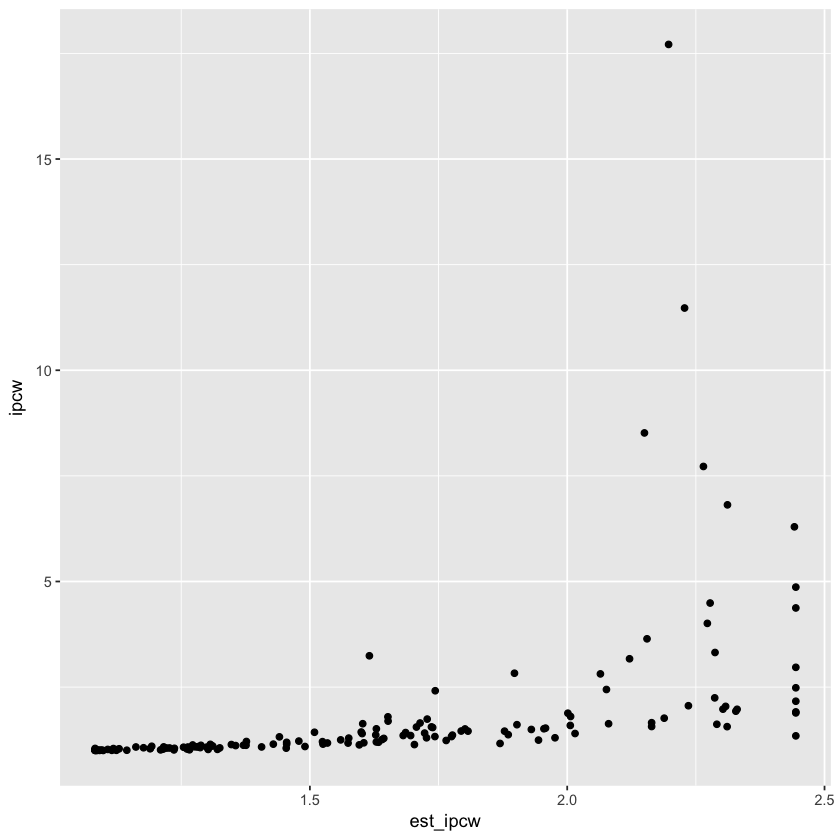

In [56]:
datas$aux_data %>% 
filter(ipcw<20) %$%
qplot(est_ipcw, ipcw)

In [19]:
models = list(
#     treat_spec = list(method = treat_all, 
#                       tune_grid = NULL),
#     control_spec = list(method = treat_none, 
#                       tune_grid = NULL),
#     rf_spec = list(method = two_model_surv_rf,
#                    tune_grid = expand.grid(num.trees = 500,
#                                            mtry = 1,
#                                            min.node.size = 3)),
#     bart_spec = list(method=one_model_surv_bart,
#                      tune_grid=expand.grid(n_times=10,
#                                            power=2,
#                                            base=0.95,
#                                            ntree=100,
#                                            ndpost=1000,
#                                            nskip=250)),
    gbm_spec = list(method = gbm_ph,
                    tune_grid = expand.grid(n.trees = seq(1,1001,20), 
                                            interaction.depth=3, 
                                            shrinkage = 0.05, 
                                            n.minobsinnode=3))
)
estimates = datas %$% get_estimates(data, models, cv_index, test_index)

In [20]:
metrics =  estimates %$% get_metrics(cv_estimates, test_estimates, datas$aux_data) 

Warning message:
In bind_rows_(x, .id): binding character and factor vector, coercing into character vectorWarning message:
In bind_rows_(x, .id): binding character and factor vector, coercing into character vectorWarning message:
In bind_rows_(x, .id): binding character and factor vector, coercing into character vectorWarning message:
In bind_rows_(x, .id): binding character and factor vector, coercing into character vector

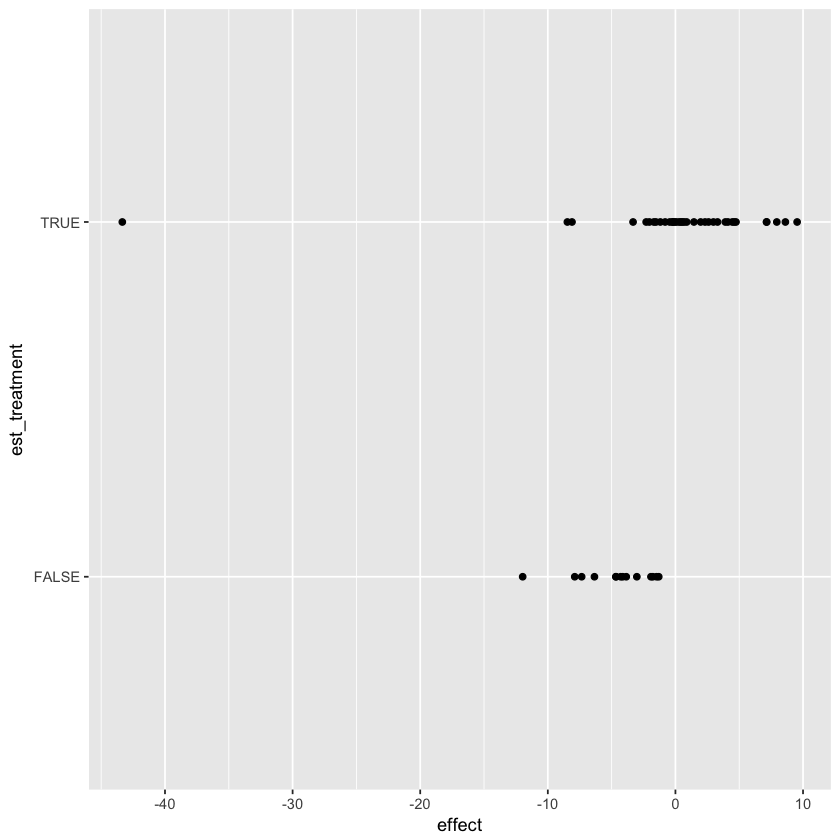

In [21]:
estimates$test_estimates %>% 
#     filter(model == "two_model_surv_rf~1000~1~3") %>%
    filter(model == "gbm_ph~81~3~0.05~3") %>%
#     filter(model == "one_model_surv_bart~10~2~0.95~100~1000~250") %>%
    inner_join(datas$aux_data, by="subject") %$%
qplot(effect, est_treatment)
# cor(effect, est_effect)

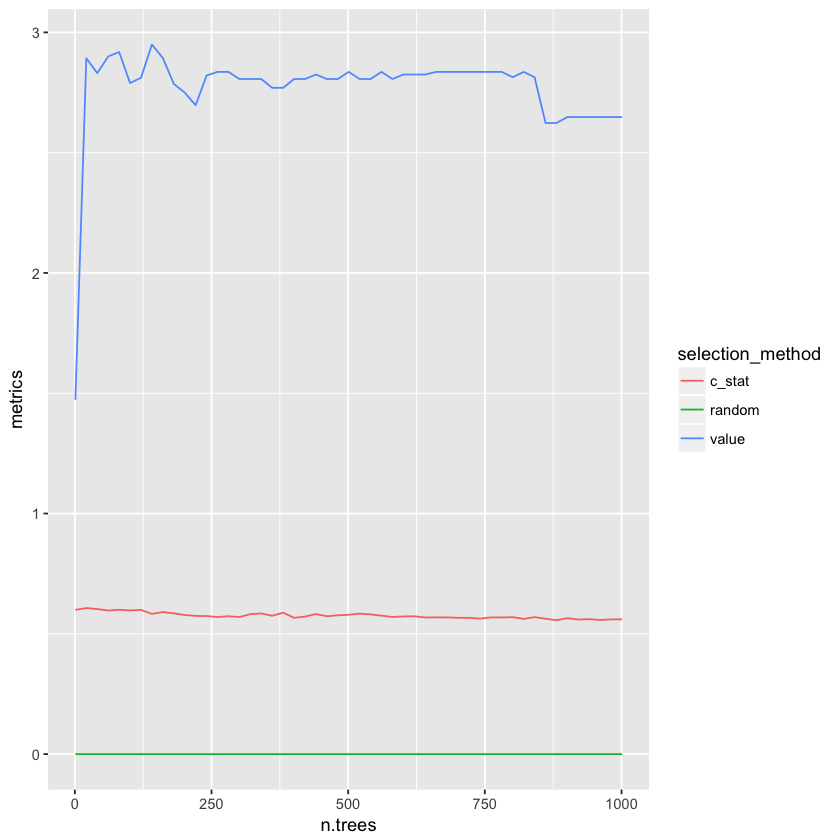

In [22]:
metrics$cv_metrics %>%
    separate(model, c("model", names(models$gbm_spec$tune_grid)), sep="~") %>%
    mutate(n.trees = as.numeric(n.trees)) %>%
# data.frame %>% str
ggplot(aes(x=n.trees, y=metrics, color=selection_method)) + 
    geom_line()

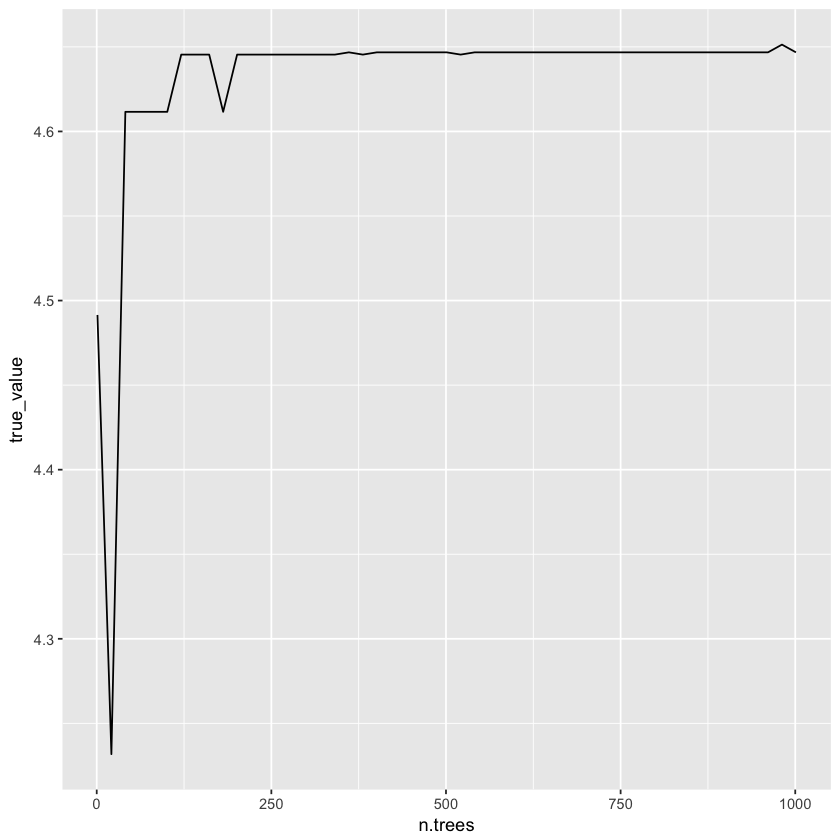

In [23]:
metrics$test_metrics %>%
    separate(model, c("model", names(models$gbm_spec$tune_grid)), sep="~") %>%
    mutate(n.trees = as.numeric(n.trees)) %>%
# data.frame %>% str
ggplot(aes(x=n.trees, y=true_value)) + 
    geom_line()

In [24]:
metrics$test_metrics %>%
    filter(model == "gbm_ph~81~3~0.05~3" | model == "one_model_surv_bart~10~2~0.95~100~1000~250") %>%
data.frame

,model,true_value
1,gbm_ph~81~3~0.05~3,4.611599


In [25]:
metrics$true_selection_metrics %>% data.frame

,model,selection_method,true_value
1,gbm_ph~21~3~0.05~3,c_stat,4.231813
2,gbm_ph~621~3~0.05~3,random,4.64677
3,gbm_ph~141~3~0.05~3,value,4.645437
4,gbm_ph~981~3~0.05~3,oracle_selector_true_value,4.651344
5,truth,oracle,6.086116
6,harm,demon,1.723971
